In [38]:
from sympy import symbols
from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd

from PIL import Image
import tensorflow as tf
import os, warnings

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub

## Importing the dataset

Firstly, the data should be imported into the pandas dataframes for easy manipulation. 

In [46]:
batch_size = 16
data_dir = "/Users/anna-alexandradanchenko/Documents/University/IdentMathFunc/Math-Functions-Identification/data"
img_height = 224
img_width = 224


# Some images are png with transparency. We need to set the white background for them so they won't appear black for the model. 
for subdir, dirs, files in os.walk(data_dir): # Iterate throught all the levels of the directories 
    for file in files:
        if file.endswith('.png'):
            img = Image.open(os.path.join(subdir, file))
            if img.mode == "RGBA":                     # Choose only images with transparency
                white_background_image = Image.new("RGBA", img.size, "WHITE") # Create a white rgba background
                white_background_image.paste(img, (0, 0), img) # Paste original png image on top of the white background
                final_img = white_background_image.convert("RGB")

                final_img.save((os.path.join(subdir, file))) # Save the image with the same filename


# for filename in os.listdir(data_dir):
#     img = Image.open(data_dir + "/" + filename)


In [33]:
df_train_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="training",

    labels='inferred',
        
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=True
)

df_valid_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="validation",

    labels='inferred',
    
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=False
)


Found 235 files belonging to 2 classes.
Using 188 files for training.


Found 235 files belonging to 2 classes.
Using 47 files for validation.


In [34]:
class_names = df_train_.class_names
print(class_names)

['linear', 'quadratic']


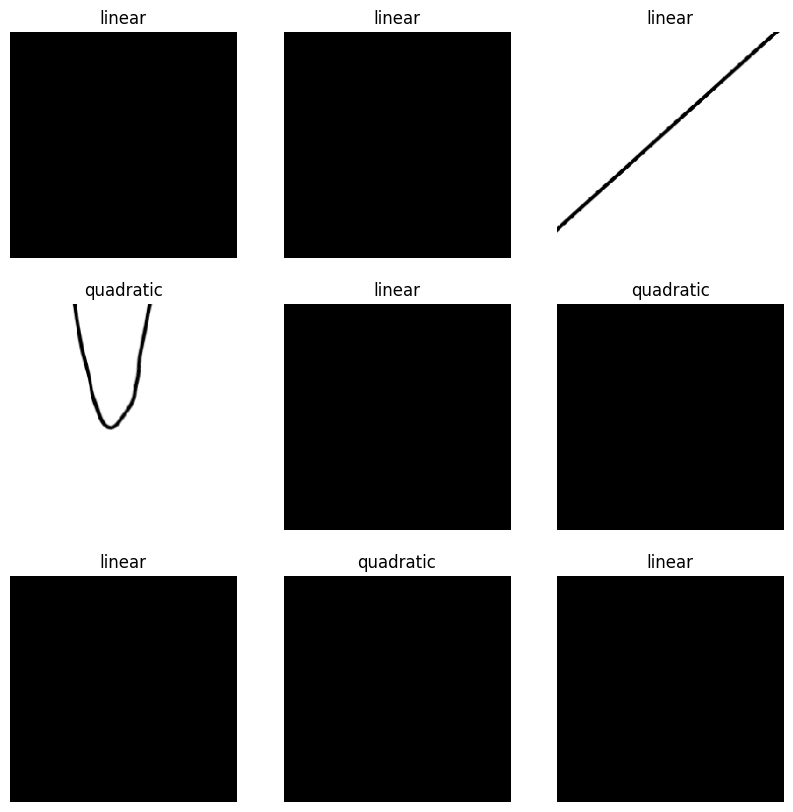

In [35]:
plt.figure(figsize=(10, 10))
for images, labels in df_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Dataset Optimization

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

df_train = (
    df_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
df_valid = (
    df_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Model Definition

In [ ]:

model = tf.keras.Sequential([
    hub.KerasLayer(
        "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/feature-vector/versions/1",
        trainable=False
        ),  
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
history = model.fit(
    df_train,
    validation_data=df_valid,
    epochs=5
    )

Epoch 1/5
12/12 [==============================] - 10s 640ms/step - loss: 0.6722 - binary_accuracy: 0.5479 - val_loss: 0.0686 - val_binary_accuracy: 1.0000
Epoch 2/5
12/12 [==============================] - 7s 606ms/step - loss: 0.5644 - binary_accuracy: 0.6862 - val_loss: 0.0116 - val_binary_accuracy: 1.0000
Epoch 3/5
12/12 [==============================] - 7s 608ms/step - loss: 0.5562 - binary_accuracy: 0.6862 - val_loss: 0.0038 - val_binary_accuracy: 1.0000
Epoch 4/5
12/12 [==============================] - 7s 608ms/step - loss: 0.5535 - binary_accuracy: 0.6915 - val_loss: 0.0025 - val_binary_accuracy: 1.0000
Epoch 5/5
12/12 [==============================] - 7s 615ms/step - loss: 0.5520 - binary_accuracy: 0.6915 - val_loss: 0.0019 - val_binary_accuracy: 1.0000


<Axes: >

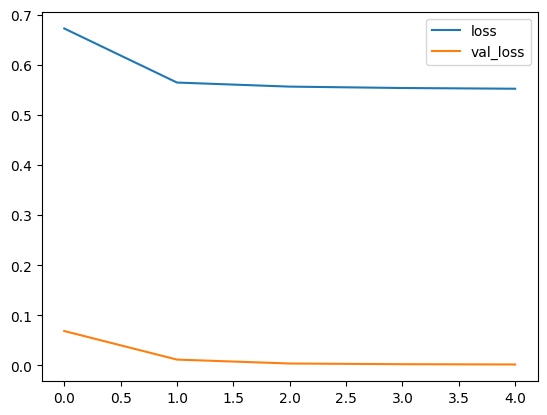

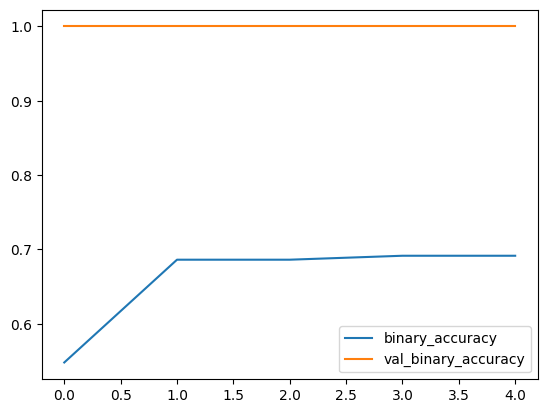

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()